# 2021/10/26
# 本代码旨在绘制季风爆发等时线，为确定CESM2敏感性实验中季风推进的情况做依据
# 使用标准出自吴老师2015年文章，这里选用三个标准
# 1.高低层风速之差  2.底层风向角度转变

In [7]:
import xarray as xr
import numpy as np
import os
import math
import sys
module_path = ["/home/sun/mycode/module/","/data5/2019swh/mycode/module/"]
sys.path.append(module_path[0])
from module_sun import *

#绘图库导入
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import matplotlib as mpl

np.set_printoptions(suppress=True)

In [8]:
def cal_jan_angle(u,v):
    u_jan      =  np.average(u[0:31,:],axis=0)
    v_jan      =  np.average(v[0:31,:],axis=0)
    angle_jan  =  u_jan.copy()
    for i in range(0,u_jan.shape[0]):
        for j in range(0,u_jan.shape[1]):
            if (u_jan[i,j]==0 and v_jan[i,j]<0):
                angle_jan[i,j] = 0 ; continue
            elif (u_jan[i,j]==0 and v_jan[i,j]>0):
                angle_jan[i,j] = 180 ; continue
                
            if u_jan[i,j] >0:
                angle_jan[i,j]  =  270 - math.degrees(np.arctan(v_jan[i,j]/u_jan[i,j]))
            else:
                angle_jan[i,j]  =  90  - math.degrees(np.arctan(v_jan[i,j]/u_jan[i,j]))

    return angle_jan

def cal_angle(u,v):
    angle  =  u.copy()
    for i in range(0,u.shape[0]):
        for j in range(0,u.shape[1]):
            if (u[i,j]==0 and v[i,j]<0):
                angle[i,j] = 0 ; continue
            elif (u[i,j]==0 and v[i,j]>0):
                angle[i,j] = 180 ; continue
                
            if u[i,j] >0:
                angle[i,j]  =  270 - math.degrees(np.arctan(v[i,j]/u[i,j]))
            else:
                angle[i,j]  =  90  - math.degrees(np.arctan(v[i,j]/u[i,j]))

    return angle


## 处理control实验

/home/sun/miniconda3/envs/swh/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1548: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


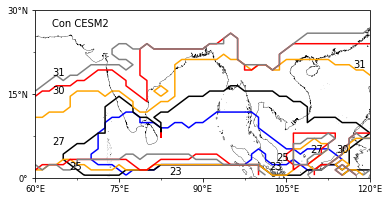

In [9]:
path  =  "/home/sun/qomo-data/cesm_year_mean/"
lat_slice   =   slice(0,30)
lon_slice   =   slice(60,140)
lev_slice1  =   [1000,975,925,850,200]
lev_slice2  =   slice(500,200)
lev_slice3  =   [850,200]

f0    =   xr.open_dataset(path+"year_mean_cesm2_control_intel_T.nc")
#计算风向差
u850  =   xr.open_dataset(path+"year_mean_cesm2_control_intel_U.nc").sel(lat=lat_slice,lon=lon_slice,lev=850)
u200  =   xr.open_dataset(path+"year_mean_cesm2_control_intel_U.nc").sel(lat=lat_slice,lon=lon_slice,lev=200)
u_delta     =  (u850-u200).U.data  #东风切变

#计算风向角 使用975、950、925的uv风场都整一波
levs  =  [975,950,925]
import math
u     =  xr.open_dataset(path+"year_mean_cesm2_control_intel_U.nc").sel(lat=lat_slice,lon=lon_slice,lev=levs[2])
v     =  xr.open_dataset(path+"year_mean_cesm2_control_intel_V.nc").sel(lat=lat_slice,lon=lon_slice,lev=levs[2])


angle_jan  =  cal_jan_angle(u.U.data,v.V.data)
#这里计算风向角计算全年的
angle      =  u.U.data.copy()
for d in range(0,angle.shape[0]):
    angle[d,:]  =  cal_angle(u.U.data[d,:],v.V.data[d,:])

#读入降水
prect      =   xr.open_dataset(path+"year_mean_cesm2_control_intel_PRECT.nc").sel(lat=lat_slice,lon=lon_slice).PRECT.data
prect_pen  =   np.zeros((73,prect.shape[1],prect.shape[2]))

#计算1月平均降水
prect_jan  =   np.average(prect[0:31,:],axis=0)


#计算侯平均
angle_pen  =  np.zeros((73,angle.shape[1],angle.shape[2]))
angle_diff =  angle_pen.copy()
u_pen      =  angle_pen.copy()
for p in range(0,73):
    angle_pen[p,:]  =  np.average(angle[p*5:(p*5+5),:],axis=0)
    angle_diff[p,:] =  angle_pen[p,:] - angle_jan
    u_pen[p,:]      =  np.average(u_delta[p*5:(p*5+5),:],axis=0)
    prect_pen[p,:]  =  np.average(prect[p*5:(p*5+5),:],axis=0)

angle_mask   = angle_diff.copy()
for i in range(0,angle_mask.shape[0]):
    for j in range(0,angle_mask.shape[1]):
        for z in range(0,angle_mask.shape[2]):
            if angle_mask[i,j,z] > 180:
                angle_diff[i,j,z]  =  abs(angle_diff[i,j,z]-360)
            if angle_diff[i,j,z] < -180:
                angle_diff[i,j,z]  =  abs(angle_diff[i,j,z]+360)

#根据上述两个量进行判断
u_judge  =  u_pen.copy() ; angle_judge  =  angle_diff.copy() ; prect_judge  =  prect_pen.copy()
date_judge  =  np.zeros(u_judge.shape)  #最终的时间序列

#判断通过为设为1
for i in range(0,date_judge.shape[0]):
    for j in range(0,date_judge.shape[1]):
        for k in range(0,date_judge.shape[2]):
            #if u_judge[i,j,k] >= 0 and angle_judge[i,j,k] >= 100 and prect_judge[i,j,k] >= 5:
            if u_judge[i,j,k] >= 0 and angle_judge[i,j,k] >= 100 and prect_judge[i,j,k]*86400*1000 >= 3:
                date_judge[i,j,k]  =  1


lonmin, lonmax = 60, 120
latmin, latmax = 0, 30
extent = [lonmin, lonmax, latmin, latmax]
proj = ccrs.PlateCarree()

fig = plt.figure()
ax = fig.add_subplot(111, projection=proj)
ax.coastlines(resolution='10m', lw=0.3)
set_map_ticks(ax, dx=15, dy=15, nx=1, ny=1, labelsize='small')
ax.set_extent(extent, crs=proj)

h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[22,:],
        levels=[1],alpha=1,colors='blue'
    )

ax.text(0.4,0.02,"23",transform=ax.transAxes,fontsize=10)
ax.text(0.7,0.05,"23",transform=ax.transAxes,fontsize=10)

h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[24,:],
        levels=[1],alpha=1,colors='black',
    )

ax.text(0.1,0.05,"25",transform=ax.transAxes,fontsize=10)
ax.text(0.72,0.1,"25",transform=ax.transAxes,fontsize=10)

h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[26,:],
        levels=[1],alpha=1,colors='orange',
    )

ax.text(0.05,0.2,"27",transform=ax.transAxes,fontsize=10)
ax.text(0.82,0.15,"27",transform=ax.transAxes,fontsize=10)

h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[29,:],
        levels=[1],alpha=1,colors='red',
    )

ax.text(0.05,0.5,"30",transform=ax.transAxes,fontsize=10)
ax.text(0.9,0.15,"30",transform=ax.transAxes,fontsize=10)
h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[30,:],
        levels=[1],alpha=1,colors='grey',
    )
ax.text(0.05,0.61,"31",transform=ax.transAxes,fontsize=10)
ax.text(0.95,0.66,"31",transform=ax.transAxes,fontsize=10)

ax.text(0.05,0.9,"Con CESM2",transform=ax.transAxes,fontsize=10)
#
#
#os.system("mkdir -p /home/sun/paint/onset_date_line")
plt.savefig('/home/sun/paint/onset_date_line/onset_con_cesm2.pdf', bbox_inches='tight',dpi=1200)
plt.show()



# 处理all_1m实验

/home/sun/miniconda3/envs/swh/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1548: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


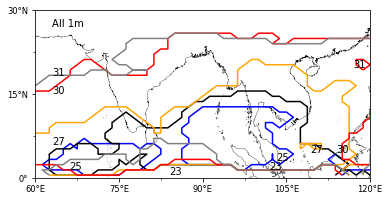

In [10]:
path  =  "/home/sun/qomo-data/cesm_year_mean/"
lat_slice   =   slice(0,30)
lon_slice   =   slice(60,140)
lev_slice1  =   [1000,975,925,850,200]
lev_slice2  =   slice(500,200)
lev_slice3  =   [850,200]

f0    =   xr.open_dataset(path+"year_mean_cesm2_topo_all_1m_intel2_T.nc")
#计算风向差
u850  =   xr.open_dataset(path+"year_mean_cesm2_topo_all_1m_intel2_U.nc").sel(lat=lat_slice,lon=lon_slice,lev=850)
u200  =   xr.open_dataset(path+"year_mean_cesm2_topo_all_1m_intel2_U.nc").sel(lat=lat_slice,lon=lon_slice,lev=200)
u_delta     =  (u850-u200).U.data  #东风切变

#计算风向角 使用975、950、925的uv风场都整一波
levs  =  [975,950,925]
import math
u     =  xr.open_dataset(path+"year_mean_cesm2_topo_all_1m_intel2_U.nc").sel(lat=lat_slice,lon=lon_slice,lev=levs[2])
v     =  xr.open_dataset(path+"year_mean_cesm2_topo_all_1m_intel2_V.nc").sel(lat=lat_slice,lon=lon_slice,lev=levs[2])


angle_jan  =  cal_jan_angle(u.U.data,v.V.data)
#这里计算风向角计算全年的
angle      =  u.U.data.copy()
for d in range(0,angle.shape[0]):
    angle[d,:]  =  cal_angle(u.U.data[d,:],v.V.data[d,:])

#读入降水
prect      =   xr.open_dataset(path+"year_mean_cesm2_topo_all_1m_intel2_PRECT.nc").sel(lat=lat_slice,lon=lon_slice).PRECT.data
prect_pen  =   np.zeros((73,prect.shape[1],prect.shape[2]))

#计算1月平均降水
prect_jan  =   np.average(prect[0:31,:],axis=0)


#计算侯平均
angle_pen  =  np.zeros((73,angle.shape[1],angle.shape[2]))
angle_diff =  angle_pen.copy()
u_pen      =  angle_pen.copy()
for p in range(0,73):
    angle_pen[p,:]  =  np.average(angle[p*5:(p*5+5),:],axis=0)
    angle_diff[p,:] =  angle_pen[p,:] - angle_jan
    u_pen[p,:]      =  np.average(u_delta[p*5:(p*5+5),:],axis=0)
    prect_pen[p,:]  =  np.average(prect[p*5:(p*5+5),:],axis=0)

angle_mask   = angle_diff.copy()
for i in range(0,angle_mask.shape[0]):
    for j in range(0,angle_mask.shape[1]):
        for z in range(0,angle_mask.shape[2]):
            if angle_mask[i,j,z] > 180:
                angle_diff[i,j,z]  =  abs(angle_diff[i,j,z]-360)
            if angle_diff[i,j,z] < -180:
                angle_diff[i,j,z]  =  abs(angle_diff[i,j,z]+360)

#根据上述两个量进行判断
u_judge  =  u_pen.copy() ; angle_judge  =  angle_diff.copy() ; prect_judge  =  prect_pen.copy()
date_judge  =  np.zeros(u_judge.shape)  #最终的时间序列

#判断通过为设为1
for i in range(0,date_judge.shape[0]):
    for j in range(0,date_judge.shape[1]):
        for k in range(0,date_judge.shape[2]):
            #if u_judge[i,j,k] >= 0 and angle_judge[i,j,k] >= 100 and prect_judge[i,j,k] >= 5:
            if u_judge[i,j,k] >= 0 and angle_judge[i,j,k] >= 100 and prect_judge[i,j,k]*86400*1000 >= 3:
                date_judge[i,j,k]  =  1


lonmin, lonmax = 60, 120
latmin, latmax = 0, 30
extent = [lonmin, lonmax, latmin, latmax]
proj = ccrs.PlateCarree()

fig = plt.figure()
ax = fig.add_subplot(111, projection=proj)
ax.coastlines(resolution='10m', lw=0.3)
set_map_ticks(ax, dx=15, dy=15, nx=1, ny=1, labelsize='small')
ax.set_extent(extent, crs=proj)

h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[22,:],
        levels=[1],alpha=1,colors='blue'
    )

ax.text(0.4,0.02,"23",transform=ax.transAxes,fontsize=10)
ax.text(0.7,0.05,"23",transform=ax.transAxes,fontsize=10)

h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[24,:],
        levels=[1],alpha=1,colors='black',
    )

ax.text(0.1,0.05,"25",transform=ax.transAxes,fontsize=10)
ax.text(0.72,0.1,"25",transform=ax.transAxes,fontsize=10)

h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[26,:],
        levels=[1],alpha=1,colors='orange',
    )

ax.text(0.05,0.2,"27",transform=ax.transAxes,fontsize=10)
ax.text(0.82,0.15,"27",transform=ax.transAxes,fontsize=10)

h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[29,:],
        levels=[1],alpha=1,colors='red',
    )

ax.text(0.05,0.5,"30",transform=ax.transAxes,fontsize=10)
ax.text(0.9,0.15,"30",transform=ax.transAxes,fontsize=10)
h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[30,:],
        levels=[1],alpha=1,colors='grey',
    )
ax.text(0.05,0.61,"31",transform=ax.transAxes,fontsize=10)
ax.text(0.95,0.66,"31",transform=ax.transAxes,fontsize=10)

ax.text(0.05,0.9,"All 1m",transform=ax.transAxes,fontsize=10)
#
#
#os.system("mkdir -p /home/sun/paint/onset_date_line")
plt.savefig('/home/sun/paint/onset_date_line/onset_all_1m.pdf', bbox_inches='tight',dpi=1200)
plt.show()

# indo 1m

/home/sun/miniconda3/envs/swh/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1548: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


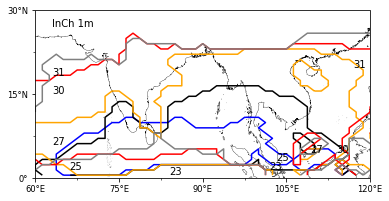

In [11]:
path  =  "/home/sun/qomo-data/cesm_year_mean/"
lat_slice   =   slice(0,30)
lon_slice   =   slice(60,140)
lev_slice1  =   [1000,975,925,850,200]
lev_slice2  =   slice(500,200)
lev_slice3  =   [850,200]

f0    =   xr.open_dataset(path+"year_mean_cesm2_topo_indo_1m_intel_U.nc")
#计算风向差
u850  =   xr.open_dataset(path+"year_mean_cesm2_topo_indo_1m_intel_U.nc").sel(lat=lat_slice,lon=lon_slice,lev=850)
u200  =   xr.open_dataset(path+"year_mean_cesm2_topo_indo_1m_intel_U.nc").sel(lat=lat_slice,lon=lon_slice,lev=200)
u_delta     =  (u850-u200).U.data  #东风切变

#计算风向角 使用975、950、925的uv风场都整一波
levs  =  [975,950,925]
import math
u     =  xr.open_dataset(path+"year_mean_cesm2_topo_indo_1m_intel_U.nc").sel(lat=lat_slice,lon=lon_slice,lev=levs[2])
v     =  xr.open_dataset(path+"year_mean_cesm2_topo_indo_1m_intel_V.nc").sel(lat=lat_slice,lon=lon_slice,lev=levs[2])


angle_jan  =  cal_jan_angle(u.U.data,v.V.data)
#这里计算风向角计算全年的
angle      =  u.U.data.copy()
for d in range(0,angle.shape[0]):
    angle[d,:]  =  cal_angle(u.U.data[d,:],v.V.data[d,:])

#读入降水
prect      =   xr.open_dataset(path+"year_mean_cesm2_topo_indo_1m_intel_PRECT.nc").sel(lat=lat_slice,lon=lon_slice).PRECT.data
prect_pen  =   np.zeros((73,prect.shape[1],prect.shape[2]))

#计算1月平均降水
prect_jan  =   np.average(prect[0:31,:],axis=0)


#计算侯平均
angle_pen  =  np.zeros((73,angle.shape[1],angle.shape[2]))
angle_diff =  angle_pen.copy()
u_pen      =  angle_pen.copy()
for p in range(0,73):
    angle_pen[p,:]  =  np.average(angle[p*5:(p*5+5),:],axis=0)
    angle_diff[p,:] =  angle_pen[p,:] - angle_jan
    u_pen[p,:]      =  np.average(u_delta[p*5:(p*5+5),:],axis=0)
    prect_pen[p,:]  =  np.average(prect[p*5:(p*5+5),:],axis=0)

angle_mask   = angle_diff.copy()
for i in range(0,angle_mask.shape[0]):
    for j in range(0,angle_mask.shape[1]):
        for z in range(0,angle_mask.shape[2]):
            if angle_mask[i,j,z] > 180:
                angle_diff[i,j,z]  =  abs(angle_diff[i,j,z]-360)
            if angle_diff[i,j,z] < -180:
                angle_diff[i,j,z]  =  abs(angle_diff[i,j,z]+360)

#根据上述两个量进行判断
u_judge  =  u_pen.copy() ; angle_judge  =  angle_diff.copy() ; prect_judge  =  prect_pen.copy()
date_judge  =  np.zeros(u_judge.shape)  #最终的时间序列

#判断通过为设为1
for i in range(0,date_judge.shape[0]):
    for j in range(0,date_judge.shape[1]):
        for k in range(0,date_judge.shape[2]):
            #if u_judge[i,j,k] >= 0 and angle_judge[i,j,k] >= 100 and prect_judge[i,j,k] >= 5:
            if u_judge[i,j,k] >= 0 and angle_judge[i,j,k] >= 100 and prect_judge[i,j,k]*86400*1000 >= 3:
                date_judge[i,j,k]  =  1


lonmin, lonmax = 60, 120
latmin, latmax = 0, 30
extent = [lonmin, lonmax, latmin, latmax]
proj = ccrs.PlateCarree()

fig = plt.figure()
ax = fig.add_subplot(111, projection=proj)
ax.coastlines(resolution='10m', lw=0.3)
set_map_ticks(ax, dx=15, dy=15, nx=1, ny=1, labelsize='small')
ax.set_extent(extent, crs=proj)

h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[22,:],
        levels=[1],alpha=1,colors='blue'
    )

ax.text(0.4,0.02,"23",transform=ax.transAxes,fontsize=10)
ax.text(0.7,0.05,"23",transform=ax.transAxes,fontsize=10)

h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[24,:],
        levels=[1],alpha=1,colors='black',
    )

ax.text(0.1,0.05,"25",transform=ax.transAxes,fontsize=10)
ax.text(0.72,0.1,"25",transform=ax.transAxes,fontsize=10)

h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[26,:],
        levels=[1],alpha=1,colors='orange',
    )

ax.text(0.05,0.2,"27",transform=ax.transAxes,fontsize=10)
ax.text(0.82,0.15,"27",transform=ax.transAxes,fontsize=10)

h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[29,:],
        levels=[1],alpha=1,colors='red',
    )

ax.text(0.05,0.5,"30",transform=ax.transAxes,fontsize=10)
ax.text(0.9,0.15,"30",transform=ax.transAxes,fontsize=10)
h  =  ax.contour(
        u.lon.data, u.lat.data, date_judge[30,:],
        levels=[1],alpha=1,colors='grey',
    )
ax.text(0.05,0.61,"31",transform=ax.transAxes,fontsize=10)
ax.text(0.95,0.66,"31",transform=ax.transAxes,fontsize=10)

ax.text(0.05,0.9,"InCh 1m",transform=ax.transAxes,fontsize=10)
#
#
#os.system("mkdir -p /home/sun/paint/onset_date_line")
plt.savefig('/home/sun/paint/onset_date_line/onset_topo_1m.pdf', bbox_inches='tight',dpi=1200)
plt.show()